In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import re
from scipy import spatial
from torch.utils.data import TensorDataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
text_file1 = open('/kaggle/input/harry-potter-final/J. K. Rowling - Harry Potter 2 - The Chamber Of Secrets.txt', 'r')
text_file2 = open('/kaggle/input/harry-potter-final/J. K. Rowling - Harry Potter 3 - Prisoner of Azkaban.txt', 'r')

book1 = text_file1.read() 
book2 = text_file2.read()

books = ''.join(( book1, book2))
chars = list(set(books)) #Obtain unique Characters
#int2char = {i:c for i, c in enumerate(chars)}
char2int = {c:i for i, c in enumerate(chars)} # Character -> key & Values -> integer indices

dataset = np.array([char2int[c] for c in books])# Integer indices are stored here

def one_hot_encoding(arr, vocab_size): # arr-conatins msg to encode, vocab_size - no of unique characters
    if(len(arr.shape) > 1): # Array has multiple dims(batch size > 1) -> then size = shape x shape
        size = np.multiply(*arr.shape)
    else:
        size = arr.shape[0]  # Array has single dim -> then size = shape 
        
    one_hot = np.zeros((size, vocab_size), dtype=np.float32) #Creating one hot vector of zeroes

    one_hot[np.arange(size), arr.flatten()] = 1 # Set value 1 at postion of index of each character in input message 'arr', arr having indices from 0 to size-1, and flatten array into 1D array

    one_hot = one_hot.reshape(*arr.shape, vocab_size)#reshape one hot array to shape of input array and dim of vocab size is added

    return one_hot

def batch_generator(data, batch_size, seq_len): #data: input data in 1D arraywith total_chars as size, seq_len : no of characters in each sequence
    chars_per_batch = batch_size * seq_len
    num_batches = len(data) // chars_per_batch # total characters/ char per batch
    data = data[:num_batches*chars_per_batch] # truncate extra chars that wouldn't make a complete batch
    data = np.reshape(data, (batch_size, -1))
    
    #For all sliding windows
    for i in range(0, data.shape[1], seq_len):#iterates over the data in sliding windows of size seq_len, starts from beginning of the data and increments by seq_len characters in each iteration.
        
        x = np.zeros((batch_size, seq_len))#For input sequences
        offset = np.zeros((batch_size, seq_len))#For target sequences

        x = data[:, i:i+seq_len]#Input data from current window 

        temp = data.flatten()#Flat input data
        temp = np.roll(temp, shift=-1)#Shift input data to 1 character to left by roll
        temp = np.reshape(temp, data.shape)#Reshape it
        offset = temp[:, i:i+seq_len]#then set that as target 

        yield x, offset

class CharRNN(nn.Module):

    def __init__(self, chars, n_layers, hidden_dim, dropout=0.3): #chars : unique chars in vocab, n_layers : no of layers in LSTM, hidden_dim : no of hidden units in each LSTM layer
        super(CharRNN, self).__init__()
    
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.vocab_size = len(chars)

        self.int2char = {i:c for i, c in enumerate(chars)}
        self.char2int = {c:i for i, c in enumerate(chars)}

        self.lstm = nn.LSTM(input_size=self.vocab_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim, self.vocab_size) #produces output predictions for the next character in the sequence.

    def forward(self, x, h): #h-> hidden outputs of all states, out->hidden output of last state

        out, h = self.lstm(x, h)
        out = self.fc(out)

        return out, h

    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_dim, device=device),
               torch.zeros(self.n_layers, batch_size, self.hidden_dim, device=device))

In [9]:
def p_sample(x, p=.9):# x - tensor containing probability distribution for entire batch, p - min probability for mass (e.g. if p=.9, take the top 90% most likely words)  0 <= p <= 1

    sorted_vals, sorted_indices = torch.sort(x, dim=-1, descending=True)#sort values in x along last dim in descending order

    cum_sum = torch.cumsum(sorted_vals, dim=-1) #cumulative sum of the sorted values sorted_vals along the last dimension
    #cum_sum where each element represents the cumulative probability up to that index
    
    small_indices = cum_sum > p #boolean mask with True for cum_sum > p and False otherwise

    small_indices = torch.roll(small_indices, shifts=1) # Shift by one to make sure first token over the threshold is also included
    small_indices[0, 0]=0 #at least one token remains after the shifting operation.

    small_indices = sorted_indices[small_indices] #index into the sorted_indices tensor on basis of indicies too small
    x[:, small_indices] = -float('inf') # Set the probabilities of tokens that are below the threshold to negative infinity so that after applying softmax, these tokens will have no chance of being chosen.

    return F.softmax(x, dim=-1)

def predict_token(model, hc, token, p=.9, argmax=False, is_char=False): #desired token is input token, hc - hidden states, argmax - if true, take the most likely token every time(doesn't produce great results) char_model - True if model isinstance of CharRNN
    token = np.array([token])

    if is_char:
        encoded = one_hot_encoding(token, model.vocab_size)
        model_input = torch.from_numpy(encoded) # one hot encoded to Pytorch 
    else:
        model_input = torch.from_numpy(token)

    model_input = model_input.to(device)
    model_input.to(torch.int64)
    model_input = torch.unsqueeze(model_input, 0) # Add a batch dimension to the tensor

    if not is_char:
        model_input = model_input.long() # Convert the tensor data type to long (integer)
        
    x, hc = model(model_input, hc) #orward pass to get output tensor x ad upadtes hidden states

    x = x.view(-1, model.vocab_size)

    if argmax:  # Check if argmax is True
        probs = F.softmax(x, dim=-1)  # Compute softmax probabilities along the last dimension of x
        token = torch.argmax(probs)  # Get the token index with the highest probability
        token_as_int = token_as_int.item()  # Convert the token tensor to an integer
    else:  # If argmax is False, create a probability distribution and sample from it
        x = F.softmax(x, dim=-1)  # Compute softmax probabilities along the last dimension of x
        probs = p_sample(x, p=p)  # Apply the p_sample function to get a filtered probability distribution
        prob_dist = torch.distributions.Categorical(probs)  # Create a categorical distribution from the probabilities
        token_as_int = prob_dist.sample().item()  # Sample a token index from the probability distribution

    if is_char:  # Check if the model is a character-level model
        token = model.int2char[token_as_int]  # Map the token index to the corresponding character
    else:  # If it's a word-level model
        token = int2word[token_as_int]  # Map the token index to the corresponding word

    return token, token_as_int, hc

def predict_sequence_tokens(model, seed_phrase='Harry', length=500, p=.9, argmax=False, include_seed=False): # seed_phrase - a phrase to feed into the model to generate a specific initial hidden state, include_seed - if true, include the seed phrase as part of the output, length - length of generated string, argmax - if true, take the most likely token every time(doesn't produce great results)
    model.eval()
    hc = model.init_hidden(1) #Initialize the hidden states for the model with a batch size of 1
    is_char = isinstance(model, CharRNN) #Check if the model is a character-level model

    token_num = 0 #Initialize the input token number to 0

    if not is_char:  # If it's not a character-level model
        split_text = re.split('([\"\.,!\?;:\s]+)', seed_phrase)  # Split the seed phrase into words and punctuation
    else:
        split_text = seed_phrase  # If it's a character-level model, use the seed phrase as is

    for token in split_text:  # Iterate over tokens in the seed phrase
        if not is_char:  # If it's not a character-level model
            num = word2int[token]  # Map the word token to its corresponding integer index
        else:
            num = model.char2int[token]  # Map the character token to its corresponding integer index in the model
        _token, token_num, hc = predict_token(model, hc, num, p=p, argmax=argmax, is_char=is_char)
        # Predict the next token based on the current token, update the input token number, and hidden states

    msg = []  # Initialize an empty list to store the generated tokens
    if include_seed:  # If include_seed is True
        msg.append(seed_phrase)  # Include the seed phrase in the output
        msg.append(_token)  # Include the last predicted token after the seed phrase
        if is_char:  # If it's a character-level model
            length -= len(seed_phrase)  # Update the length to account for the seed phrase length
        else:
            length -= 1  # Decrement the length by 1 since one token has been predicted

    for i in range(length):  # Iterate over the specified length to predict the remaining tokens
        word, token_num, hc = predict_token(model, hc, token_num, p=p, argmax=argmax, is_char=is_char)
        # Predict the next token based on the current input token number, update the input token number, and hidden states
        msg.append(word)  # Append the predicted token to the message list

    result = ''.join(msg)  # Concatenate the tokens to form the output string
    return result  # Return the generated output string

In [16]:
import torch
import torch.nn as nn
import numpy as np
import time

perplexity_values = []
      
loss_fn = nn.CrossEntropyLoss()  # Rename loss to loss_fn

def train(model, data, optimizer, loss_fn, seq_len=100, batch_size=20, epochs=10, summary=10, print_time=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if print_time:
        prev_time = time.time()

    iteration = 0
    is_char = isinstance(model, CharRNN)
    model.train()

    total_loss = 0
    total_tokens = 0

    for e in range(epochs):
        # Reset / initialize (hidden state, cell) params
        hc = model.init_hidden(batch_size)

        rolling_loss = []

        for x, offset in batch_generator(data, batch_size=batch_size, seq_len=seq_len):
            iteration += 1

            if is_char: # only char model needs one hot encoding
                x = one_hot_encoding(x, model.vocab_size)

            # Copy over data in hc to prevent backprop through entire epoch(noticeably improves training time)
            hc = [layer.data for layer in hc]
            hc = tuple(hc)

            # Move to tensors and gpu if applicable
            x = torch.from_numpy(x)
            x = x.to(device)
            offset = torch.from_numpy(offset)
            offset = offset.to(device)

            # Clear gradients and predict
            optimizer.zero_grad()
            if not is_char: # Since x is words as integers, for word2vec embedding must explicitly change type
                x = x.long()
            prediction, hc = model(x, hc)

            # Reshape so that it looks like one giant batch of batch_size * seq_len predicting on vocab_size classes
            # which is needed for the cross entropy loss function
            prediction = prediction.view(-1, model.vocab_size)
            offset = offset.contiguous().view(-1)

            # Get loss and take step
            loss = loss_fn(prediction, offset.long())  # Use loss_fn instead of loss
            total_loss += loss.item() * offset.size(0)  # accumulate loss for later perplexity calculation
            total_tokens += offset.size(0)

            loss.backward() # forgot this initially, oops!
            nn.utils.clip_grad_norm_(model.parameters(), 10) # Avoid exploding gradients
            optimizer.step()

            rolling_loss.append(loss.item())

            if iteration % summary == 0:
                if print_time:
                    print("---------------------------------------Epoch No:{0}---------------------------------------------\n".format(e+1))
                    print('Iteration: {1}, Current loss: {2:.6f}, Average loss over last {3}, Rolling Loss: {4:.6f}, Time {3}, iterations took: {5:.3f}'.format(iteration, loss.item(), summary, np.mean(rolling_loss), time.time() - prev_time))
                    prev_time = time.time()
                else:
                    print("---------------------------------------Epoch No:{0}-----------------------------------------------\n".format(e+1))
                    print('Iteration: {1}, Current loss: {2:.6f}, Average loss over last {3}, Rolling Loss: {4:.6f}'.format(e+1, iteration, loss.item(), summary, np.mean(rolling_loss)))
                print('Sequence: \n',predict_sequence_tokens(model, length=20))
                print('\n')
                model.train()
                rolling_loss = []

        # Calculate perplexity for this epoch
        average_loss = total_loss / total_tokens
        perplexity = np.exp(average_loss)
        perplexity_values.append(perplexity)
        print(f'Perplexity for epoch {e+1}: {perplexity}')

    # Calculate perplexity after all epochs
    average_loss = total_loss / total_tokens
    perplexity = np.exp(average_loss)
    print(f'Perplexity after all epochs: {perplexity}')


In [17]:
# Hyperparameters
num_layers = 4
hidden_dimension = 512
dropout_prob = 0.3
lr = 1e-3

char_rnn = CharRNN(chars, n_layers=num_layers, hidden_dim=hidden_dimension, dropout=dropout_prob)
char_rnn = char_rnn.to(device)
optim = torch.optim.Adam(char_rnn.parameters(), lr=lr)

In [21]:
#More hyperparameters (these just affect training)
show_time = False
summary = 5
seq_len = 100
batch_size = 100
reset_optimizer = False
lr = 1e-3 # won't be used unless reset optimizer is True

if reset_optimizer:
    optim = torch.optim.Adam(char_rnn.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()  # Define the loss function
train(char_rnn, dataset, optim, loss_fn, seq_len=seq_len, batch_size=batch_size,epochs=100,
      summary=summary, print_time=show_time)



---------------------------------------Epoch No:1-----------------------------------------------

Iteration: 5, Current loss: 3.439162, Average loss over last 5, Rolling Loss: 4.116244
Sequence: 
 $	bk yssoguotdysicro


---------------------------------------Epoch No:1-----------------------------------------------

Iteration: 10, Current loss: 3.259378, Average loss over last 5, Rolling Loss: 3.272160
Sequence: 
 arwdrs
bym  
ituhs.l


---------------------------------------Epoch No:1-----------------------------------------------

Iteration: 15, Current loss: 3.249682, Average loss over last 5, Rolling Loss: 3.236895
Sequence: 
 wgastr."lesra.eeg" t


---------------------------------------Epoch No:1-----------------------------------------------

Iteration: 20, Current loss: 3.254434, Average loss over last 5, Rolling Loss: 3.236089
Sequence: 
 ehw.ns,tlpeiwuoacwig


---------------------------------------Epoch No:1-----------------------------------------------

Iteration: 25, Curr

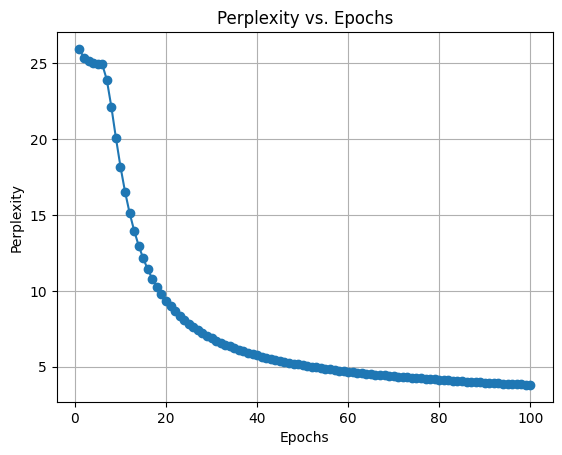

In [22]:
import matplotlib.pyplot as plt

plt.plot(range(1, 100+1), perplexity_values, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Epochs')
plt.grid(True)
plt.show()

In [24]:
# Generate a sequence of arbitrary length
seed_phrase='Harry' # Initializes hidden state of network
length=500
p=.9 # 0 <= p <=1  sample from the top p most likely characters
greedy=False # choose most likely character every time(don't reccomend, easy for model to get off track and never recover)
include_seed=False # Include seed in output

sample = predict_sequence_tokens(char_rnn, seed_phrase=seed_phrase, length=length, p=p, argmax=greedy, include_seed=include_seed)

print(sample)
with open("/kaggle/working/sample_output.txt", "w") as file:
    file.write(sample)

ng Harry's head, coming,
hooted a knight was at its fixed. Ere under Ron's feet. Harry let out a
mouthfully. Aspectitedy, frantically, and she did hard.

"Eat, at everyone's face. Daid!" Ron wasn't leating out, drawing
rubbing, too, returning with what seemed out a mouth-eather-up-decufid, emility
house. Lockhart had backed up with broom; down at him, he would look through
the worst, Harry pointed to him.

"How werenate be?"

But Sirius almost little blue eyes. With callap, charming-younded hers
